In [12]:
from utils import *
import numpy as np
import tensorflow as tf
from tensorflow import keras
import csv
import os
import sys
sys.path.append("/scratch/fb590/code/ion-cdft/cdft")
import minimise
import pandas as pd
import scipy.constants as const
from scipy.integrate import simpson
import seaborn as sns

# Enable or disable Tensor Float 32 Execution
tf.config.experimental.enable_tensor_float_32_execution(False)
import matplotlib.pyplot as plt

In [2]:
input_bins = 1501
dx=0.004
kB  = 1
T = 1

model = "model_0002"

model_H_path = f"/scratch/fb590/cDFT_models/{model}_H.keras"
model_O_path = f"/scratch/fb590/cDFT_models/{model}_O.keras"
model_H = keras.models.load_model(model_H_path)
model_O = keras.models.load_model(model_O_path)

ratios = [0.0,0.1,0.2,0.3,0.4,0.5]

from cmcrameri import cm
colours = cm.acton(np.linspace(0, 0.9, len(ratios)))

In [3]:
rho_range_06 = np.linspace(0.0, 0.6, 50)
mu_values = []
for rho in rho_range_06:
    c1 = c1_twotype(model_H, model_O, np.array([rho]), np.array([rho]), input_bins,dx)
    mu = get_betamu(rho,c1)
    mu_values.append(mu)

I0000 00:00:1741190329.039126 2667853 service.cc:145] XLA service 0x7f426c007330 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1741190329.039151 2667853 service.cc:153]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1741190329.077182 2667853 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
/scratch/fb590/azeotrope_cDFT/utils.py:164: RuntimeWarning: divide by zero encountered in log
  betamu = np.log(rho) - c1[0]


In [7]:
def get_P(rho_H, rho_O):
    z_range = np.ones(1)
    total_rho = rho_H + rho_O
    ratio = rho_H / total_rho

    rhoH_array = z_range * total_rho * ratio
    rhoO_array = z_range * total_rho * (1-ratio)

    Fexc = kB * T * betaFexc_twotype(model_H, model_O, rhoH_array, rhoO_array, input_bins, dx)
    c1H, c1O, = c1_twotype(model_H, model_O, rhoH_array, rhoO_array,input_bins,dx)
    derivPhiH = -np.mean(c1H) * kB * T
    derivPhiO = -np.mean(c1O) * kB * T

    P = (derivPhiH + kB*T) * total_rho * ratio + (derivPhiO + kB*T) * total_rho * (1-ratio) - Fexc/dx
    return P

0.09413851828410708

/tmp/ipykernel_2667726/3324727849.py:4: RuntimeWarning: invalid value encountered in scalar divide
  ratio = rho_H / total_rho


<Axes: >

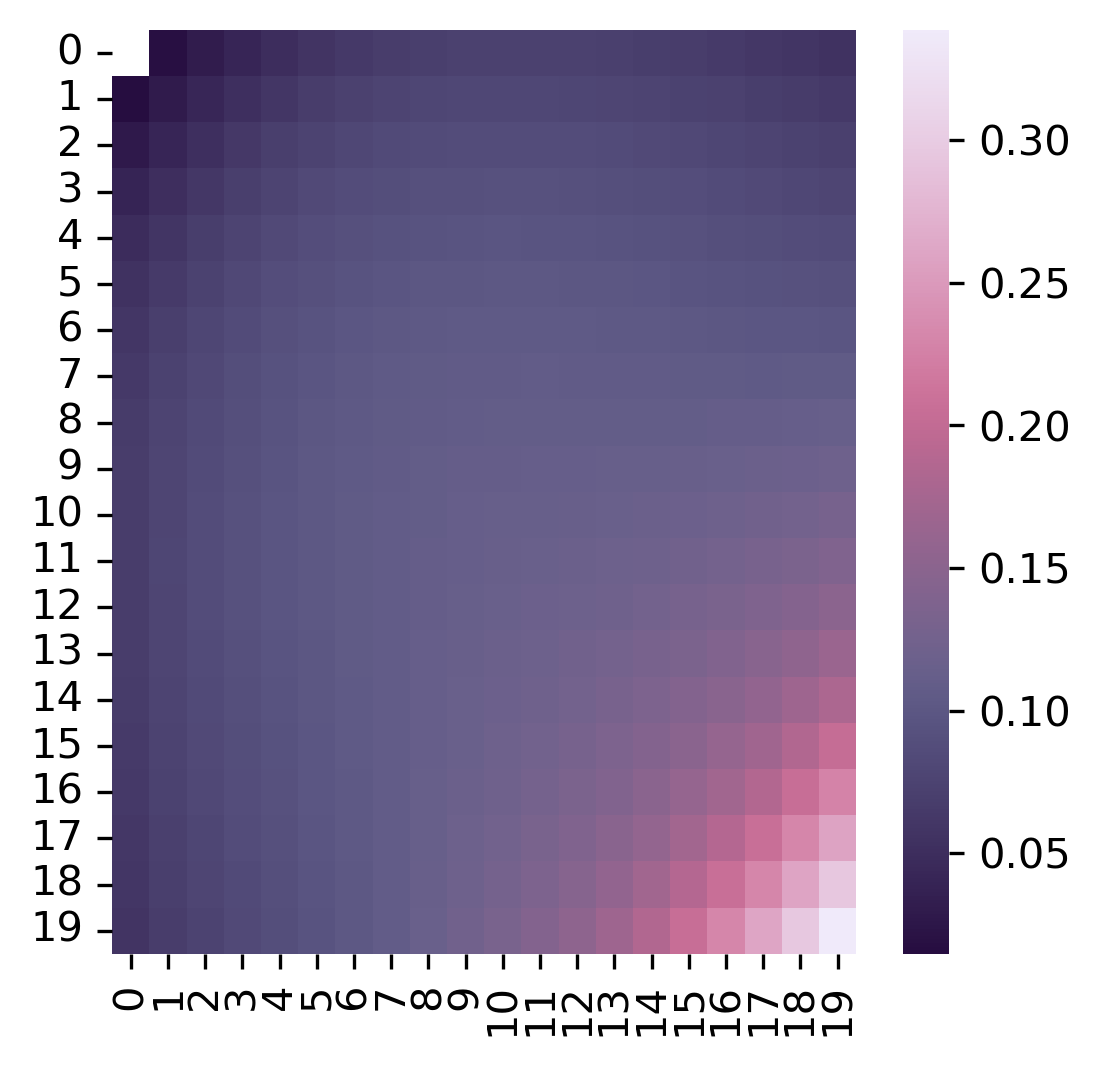

In [19]:
fig, ax = plt.subplots(figsize=(4, 4))

rho_H_range = np.linspace(0,0.3,20)
rho_O_range = np.linspace(0,0.3,20)

P = np.array([[get_P(rho_H, rho_O) for rho_H in rho_H_range] for rho_O in rho_O_range])
sns.heatmap(P, xticklabels=True, yticklabels=True, cmap=cm.acton)

/tmp/ipykernel_2667726/3324727849.py:4: RuntimeWarning: invalid value encountered in scalar divide
  ratio = rho_H / total_rho


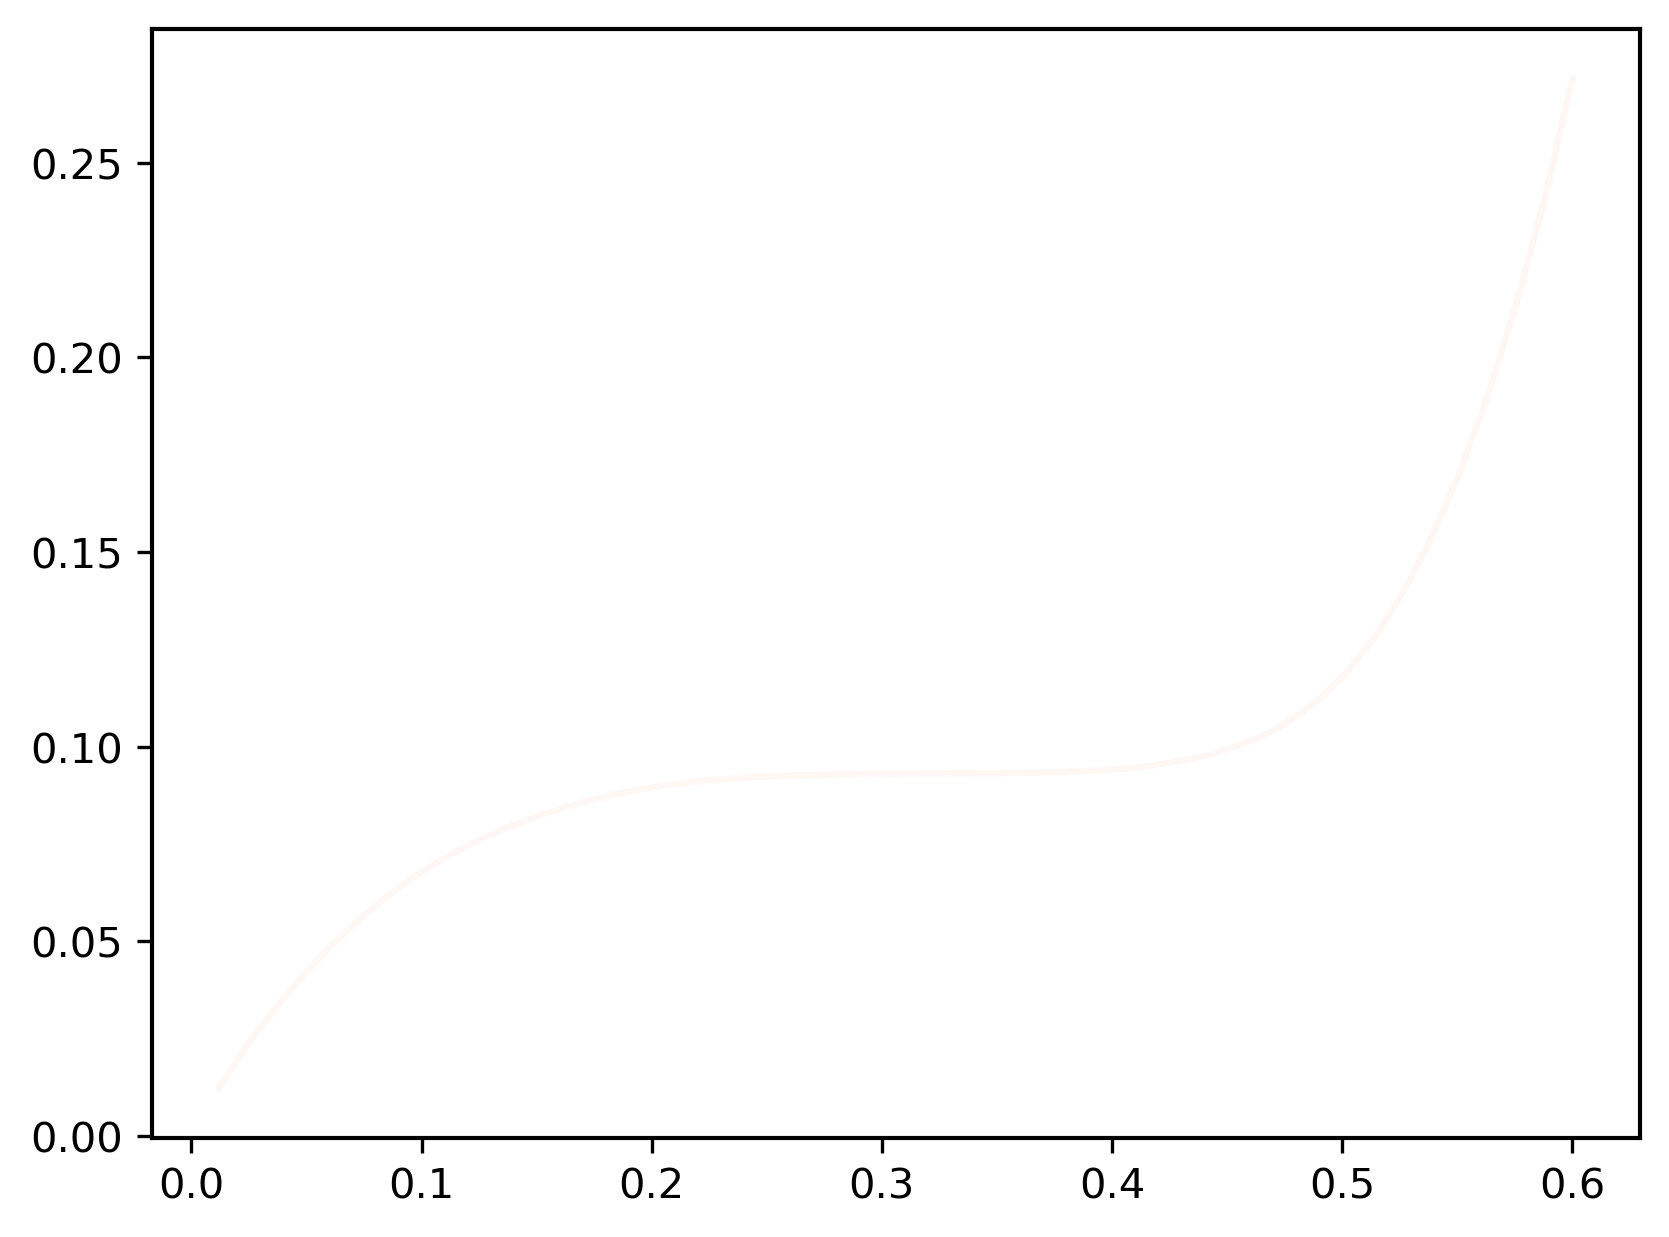

In [8]:
r = 0.2
total_range = np.linspace(0.0, 0.6, 50)
P_values =[]

for total in total_range:
    rho_H = r * total
    rho_O = (1-r) * total
    P = get_P(rho_H, rho_O)
    P_values.append(P)

plt.plot(total_range, P_values)